<a href="https://colab.research.google.com/github/jadhav-rakesh/Flower_Classification/blob/main/flower_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.python.keras import layers

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    "tf_flowers",
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]']
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_classes = dataset_info.features["label"].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1


print(f"Total Number of Classes: {num_classes}")
print(f"Total Number of Training Images: {num_training_examples}")
print(f"Total Number of Validation Images: {num_validation_examples}")

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101


In [5]:
for i, example in enumerate(training_set.take(5)):
    print("Image {} shape: {} label: {}".format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
feature_extractor.trainable = False

In [11]:
import tf_keras

model = tf_keras.Sequential()

model.add(feature_extractor)
model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 module_wrapper (ModuleWrap  (None, 5)                 6405      
 per)                                                            
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [13]:
model.compile(
    optimizer ="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

EPOCHS = 5

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
81/81 [==============================] - 216s 3s/step - loss: 0.5784 - accuracy: 0.7925 - val_loss: 0.4176 - val_accuracy: 0.8601
Epoch 2/5
81/81 [==============================] - 202s 3s/step - loss: 0.3448 - accuracy: 0.8824 - val_loss: 0.3312 - val_accuracy: 0.8910
Epoch 3/5
81/81 [==============================] - 180s 2s/step - loss: 0.2733 - accuracy: 0.9093 - val_loss: 0.3105 - val_accuracy: 0.8910
Epoch 4/5
81/81 [==============================] - 227s 3s/step - loss: 0.2311 - accuracy: 0.9249 - val_loss: 0.2981 - val_accuracy: 0.8983
Epoch 5/5
81/81 [==============================] - 221s 3s/step - loss: 0.2003 - accuracy: 0.9401 - val_loss: 0.2803 - val_accuracy: 0.9028


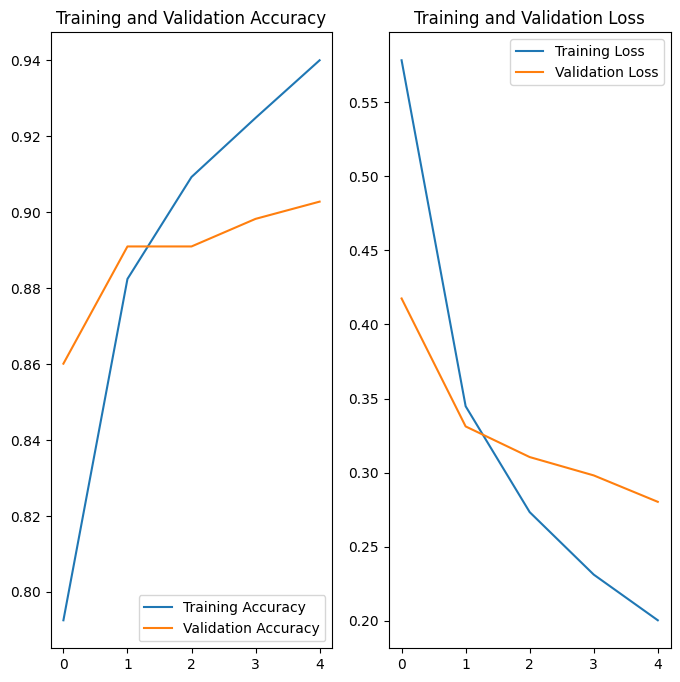

In [15]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [16]:
class_names = np.array(dataset_info.features["label"].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [18]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 2s 2s/step
['tulips' 'roses' 'sunflowers' 'tulips' 'roses' 'dandelion' 'dandelion'
 'tulips' 'tulips' 'sunflowers' 'sunflowers' 'tulips' 'roses' 'daisy'
 'sunflowers' 'tulips' 'roses' 'sunflowers' 'roses' 'tulips' 'sunflowers'
 'dandelion' 'dandelion' 'sunflowers' 'sunflowers' 'sunflowers' 'tulips'
 'tulips' 'dandelion' 'roses' 'tulips' 'tulips']


In [19]:
print("Labels:", label_batch)
print("Predicted labels:", predicted_ids)

Labels: [2 4 2 2 4 0 0 2 2 3 3 2 4 1 3 2 4 3 4 2 3 0 0 3 3 3 2 2 0 4 2 2]
Predicted labels: [2 4 3 2 4 0 0 2 2 3 3 2 4 1 3 2 4 3 4 2 3 0 0 3 3 3 2 2 0 4 2 2]


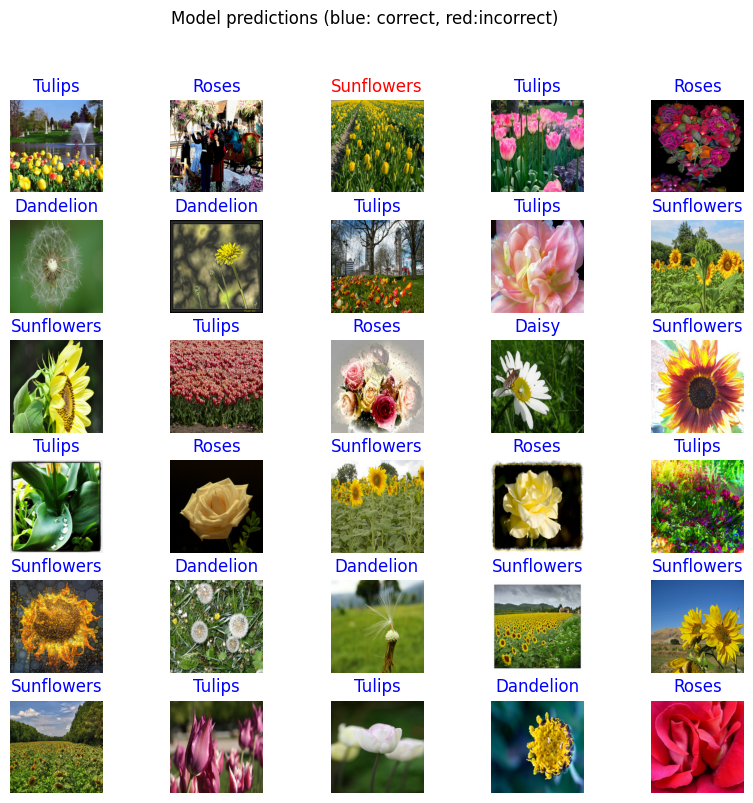

In [23]:
plt.figure(figsize=(10, 9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color = color)
    plt.axis("off")
_ = plt.suptitle("Model predictions (blue: correct, red:incorrect)")

In [26]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    "tf_flowers",
    with_info=True,
    as_supervised=True,
    split=["train[:70%]", "train[70%:]"]
)

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3),
                                   trainable = False)

model_inception = tf_keras.Sequential()

model_inception.add(feature_extractor)
model_inception.add(layers.Dense(num_classes))

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 module_wrapper_1 (ModuleWr  (None, 5)                 10245     
 apper)                                                          
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [28]:
model_inception.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

EPOCHS = 2

history = model_inception.fit(train_batches,
                              epochs=EPOCHS,
                              validation_data=validation_batches)

Epoch 1/2
81/81 [==============================] - 918s 11s/step - loss: 0.7423 - accuracy: 0.7345 - val_loss: 0.4755 - val_accuracy: 0.8492
Epoch 2/2
81/81 [==============================] - 950s 12s/step - loss: 0.3938 - accuracy: 0.8723 - val_loss: 0.3513 - val_accuracy: 0.8801
